# Part Radiation

In [60]:
import os
import numpy
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import gaussian_kde, pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [61]:
storage_folder = '/disk2/workspace/20231125'

In [62]:
def read_site_csv(csv_filename):
    csv_data = numpy.genfromtxt(csv_filename, delimiter=',', dtype=str)
    csv_v = csv_data[:, 1]
    csv_v = csv_v.astype(float)
    return csv_data[:, 0], csv_v


def half_hour_to_10min_by_nan(arr_half_hour):
    new_len = 3 * len(arr_half_hour)
    arr_10min = numpy.full(new_len, numpy.nan)
    arr_10min[::3] = arr_half_hour
    return arr_10min


def mapping_comparison(site_obs, site_cal, fig_title='', save_flag=0):
    
    data_labels = ['Rsd', 'Rsu', 'Rld', 'Rlu']
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    
    axis_min_max = [[0, 1200], [0, 600], [0, 600], [0, 600]]
    
    nan_indices = numpy.isnan(site_obs[0])\
    |numpy.isnan(site_obs[1])\
    |numpy.isnan(site_obs[2])\
    |numpy.isnan(site_obs[3])\
    |numpy.isnan(site_cal[0])\
    |numpy.isnan(site_cal[1])\
    |numpy.isnan(site_cal[2])\
    |numpy.isnan(site_cal[3])
    
    count_idx = 0
    for c_idx in range(2):
        for v_idx in range(2):
            site_obs_item = site_obs[count_idx]
            site_cal_item = site_cal[count_idx]
            axis_min = axis_min_max[count_idx][0]
            axis_max = axis_min_max[count_idx][1]
            # 删除包含 NaN 值的位置
            x = site_obs_item[~nan_indices]
            y = site_cal_item[~nan_indices]

            # 绘制1:1参考线
            x_11 = numpy.arange(axis_min, axis_max + 1)
            y_11 = 1 * x_11
            axes[c_idx, v_idx].plot(x_11, y_11, color='k', linewidth=1, linestyle='--',)

            # 使用线性回归模型拟合数据
            model = LinearRegression()
            x = x.reshape(-1, 1)
            model.fit(x, y)
            y_pred = model.predict(x)
            xx = numpy.arange(axis_min, axis_max + 0.1, 0.05)
            yy_pred = model.coef_[0] * xx + model.intercept_

            # 绘制密度散点图
            xy = numpy.vstack([x.flatten(), y])
            z = gaussian_kde(xy)(xy)
            idx = z.argsort()
            x_, y_, z = x[idx], y[idx], z[idx]
            z = (z-numpy.min(z))/(numpy.max(z)-numpy.min(z))*100
            axes[c_idx, v_idx].scatter(x_, y_, marker='o', c=z, s=8, cmap='turbo')

            # 绘制散点图和回归线
            axes[c_idx, v_idx].plot(xx, yy_pred, color='red')


            # 添加标签
            axes[c_idx, v_idx].set_xlabel(data_labels[count_idx] + ' radiation observed at site (W/m²)')
            axes[c_idx, v_idx].set_ylabel(data_labels[count_idx] + ' radiation calculated for ET (W/m²)')

            # 计算散点个数
            num = numpy.count_nonzero(~numpy.isnan(x))

            # 计算回归方程
            equation = f'y = {model.coef_[0]:.2f} * x + {model.intercept_:.2f}'

            # 计算评估指标
            r2 = r2_score(y, y_pred)
            rmse = numpy.sqrt(mean_squared_error(y, y_pred))
            bias = numpy.mean(y_pred - y)
            mae = mean_absolute_error(y, y_pred)

            print('N:', num)
            print('R²:', r2)
            print('RMSE:', rmse)
            print('Bias:', bias)
            print('MAE', mae)

            axes[c_idx, v_idx].annotate(f'N: {num:d}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10)
            axes[c_idx, v_idx].annotate(equation, xy=(0.05, 0.90), xycoords='axes fraction', fontsize=10)
            axes[c_idx, v_idx].annotate(f'R²: {r2:.2f}', xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10)
            axes[c_idx, v_idx].annotate(f'RMSE: {rmse:.2f}', xy=(0.05, 0.80), xycoords='axes fraction', fontsize=10)
            axes[c_idx, v_idx].annotate(f'Bias: {bias:.2f}', xy=(0.05, 0.75), xycoords='axes fraction', fontsize=10)
            axes[c_idx, v_idx].annotate(f'MAE: {mae:.2f}', xy=(0.05, 0.70), xycoords='axes fraction', fontsize=10)

            # 显示图形
            axes[c_idx, v_idx].set_xlim((axis_min, axis_max))
            axes[c_idx, v_idx].set_ylim((axis_min, axis_max))
            
            count_idx = count_idx + 1
        
    plt.suptitle(fig_title)
    if save_flag:
        plt.savefig(storage_folder + '/Radiation ' + fig_title + '.png', dpi=300)
    else:
        plt.show()

    
def show_radiation_curve_week(site_name, week_idx, obs_timelist, site_obs_list, site_cal_list, save_flag=0):
    fig, axes = plt.subplots(len(site_obs_list), 1, figsize=(16, 4 * len(site_obs_list)))
    r_labels = ['Rsd', 'Rsu', 'Rld', 'Rlu']
    
    for i in range(len(site_obs_list)):
        site_obs = site_obs_list[i]
        site_cal = site_cal_list[i]
        
        week_obs_10min = site_obs[7*24*6*week_idx:7*24*6*(week_idx+1)]
        week_obs_hh = week_obs_10min[::3]

        week_cal_10min = site_cal[7*24*6*week_idx:7*24*6*(week_idx+1)]
#         week_cal_hh = numpy.mean(week_cal_10min.reshape(-1, 3), axis=1)
        week_cal_hh = week_cal_10min[::3]

        week_timelist_10min = obs_timelist[7*24*6*week_idx:7*24*6*(week_idx+1)]
        # week_timelist_hh = week_timelist_10min[::3]

        formatted_dates = []
        for date_string in week_timelist_10min:
            dt_object = datetime.strptime(date_string, "%Y-%m-%dT%H:%M:%SZ")
            formatted_date = dt_object.strftime("%-H:%M")
            formatted_dates.append(formatted_date)

        axes[i].plot(numpy.linspace(0, len(week_obs_hh), len(week_obs_hh)), week_obs_hh, 
                     '-', color='black', label='EC-site observed '+r_labels[i]+' radiation')
        axes[i].plot(numpy.linspace(0, len(week_cal_hh), len(week_cal_hh)), week_cal_hh, 
                     '-', color='red', label='Input '+r_labels[i]+' radiation for ET estimation')
        axes[i].plot(numpy.linspace(0, len(week_cal_hh), len(week_cal_hh)), week_cal_hh, 
                     '.', color='red')
        
        axes[i].set_ylabel(r'$W/m^2$', fontsize=14)
        axes[i].set_xlim(0,len(week_obs_hh))
#         axes[i].set_ylim((-100,950))
        title_str = site_name + ' ' + (week_timelist_10min[0] + ' - ' + week_timelist_10min[-1]).replace('T',' ').replace('Z','')
        axes[i].set_title(title_str)
        axes[i].legend()
    plt.xticks(numpy.linspace(0, len(week_obs_hh), int(len(week_obs_hh)/6)), formatted_dates[::18], rotation=45, ha='right')
    if save_flag:
        plt.savefig(storage_folder + '/Radiation ' + fig_title + '.png', dpi=300)
    else:
        plt.show()

## CRK

N: 18920
R²: 0.9663080776689262
RMSE: 54.77217168104812
Bias: 3.1726559364171915e-15
MAE 25.67226186057065
N: 18920
R²: 0.849577873635501
RMSE: 17.80520586681089
Bias: 3.2687970253995308e-15
MAE 9.196295177293191
N: 18920
R²: 0.9217525329951171
RMSE: 20.1346656997408
Bias: 4.341971931164891e-14
MAE 15.78138022922491
N: 18920
R²: 0.9422732925829151
RMSE: 16.1202103495852
Bias: -1.9708923241379525e-15
MAE 10.995808045342365


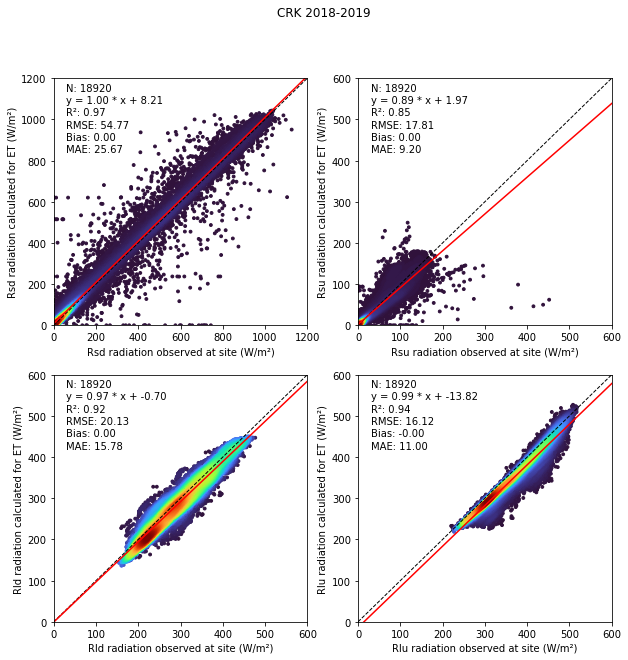

In [75]:
site_name = 'CRK'
data_labels = ['AMATERASS_Rsd', 'Rsu', 'ERA5_Rld_10min', 'RluV002']

SITE_CSV = '/disk2/Data/FluxSite4ET/validation/'+site_name+'_2018_2019_L2.csv'
csv_data = numpy.genfromtxt(SITE_CSV, delimiter=',', dtype=str)
site_obs = [half_hour_to_10min_by_nan(csv_data[:,1][1:].astype(float)), 
            half_hour_to_10min_by_nan(csv_data[:,2][1:].astype(float)), 
            half_hour_to_10min_by_nan(csv_data[:,3][1:].astype(float)), 
            half_hour_to_10min_by_nan(csv_data[:,4][1:].astype(float))]
site_cal = []
obs_timelist = None
for data_label in  data_labels:
    SITE_CAL_CSV = '/disk2/Data/FluxSite4ET/'+site_name+'_'+data_label+'.csv'
    cal_timelist, site_cal_item = read_site_csv(SITE_CAL_CSV)
    obs_timelist = cal_timelist
    site_cal.append(site_cal_item)
######################################
site_cal[0]=numpy.roll(site_cal[0], 2)
site_cal[1]=numpy.roll(site_cal[1], 2)
site_cal[2]=numpy.roll(site_cal[2], -9)
# site_cal[3]=numpy.roll(site_cal[3], 3)+12
site_cal[3]=numpy.roll(site_cal[3], 5)
######################################

mapping_comparison(site_obs, site_cal, site_name + ' 2018-2019', 1)

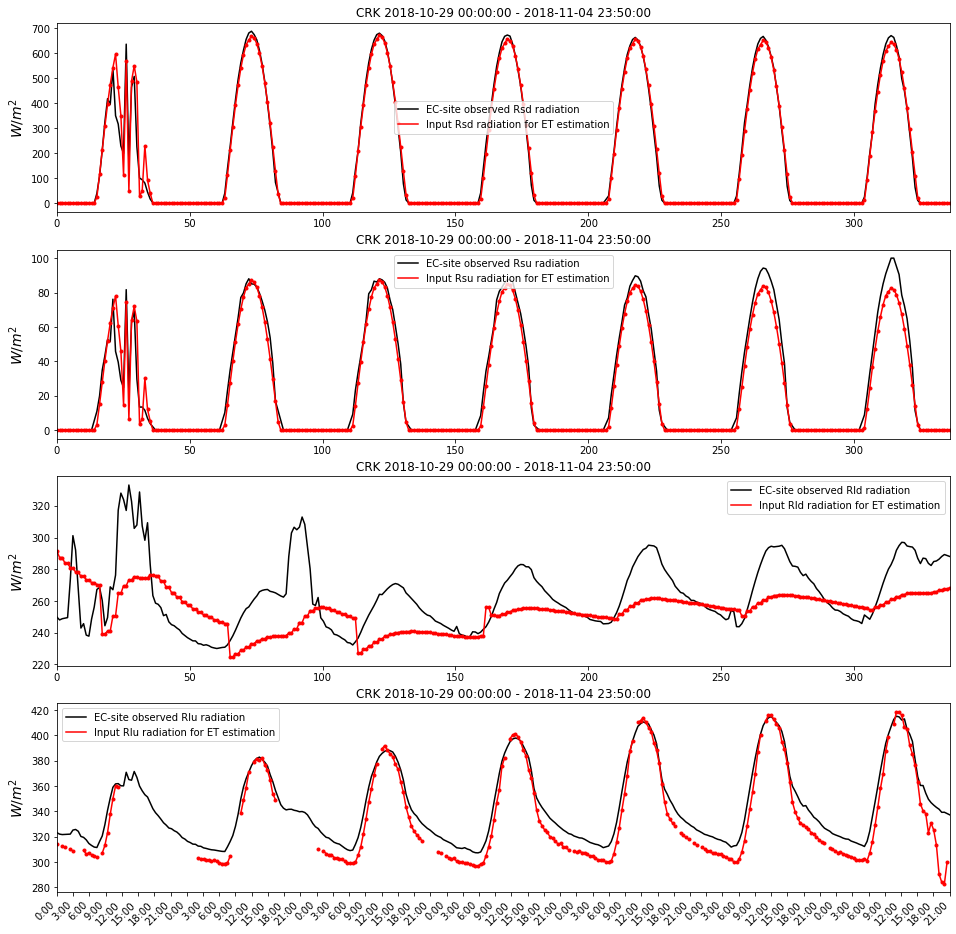

In [76]:
show_radiation_curve_week(site_name, 43, obs_timelist, site_obs, site_cal, 0)

In [77]:
r_labels = ['Rsd', 'Rsu', 'Rld', 'Rlu']
for idx in range(len(r_labels)):
    r_data = site_cal[idx]
    r_label = r_labels[idx]
    r_record = r_data.astype(str)
    r_lu_csv_ = numpy.column_stack((obs_timelist, r_record))
    numpy.savetxt(os.path.join(storage_folder, site_name+'_'+r_label+'.csv'), r_lu_csv_, delimiter=",", fmt='%s')

## GCK

N: 19448
R²: 0.9593515160186507
RMSE: 59.84845828173559
Bias: -1.6835566260708255e-15
MAE 28.558002378056557
N: 19448
R²: 0.9070500687532038
RMSE: 12.809232568902951
Bias: -5.518324496565484e-15
MAE 6.796270155673746
N: 19448
R²: 0.8973195730531043
RMSE: 23.105971169623785
Bias: -1.510524417280213e-14
MAE 18.761539640611552
N: 19448
R²: 0.9387082497657355
RMSE: 14.976940626185835
Bias: 1.2392847386354688e-14
MAE 10.24042866754192


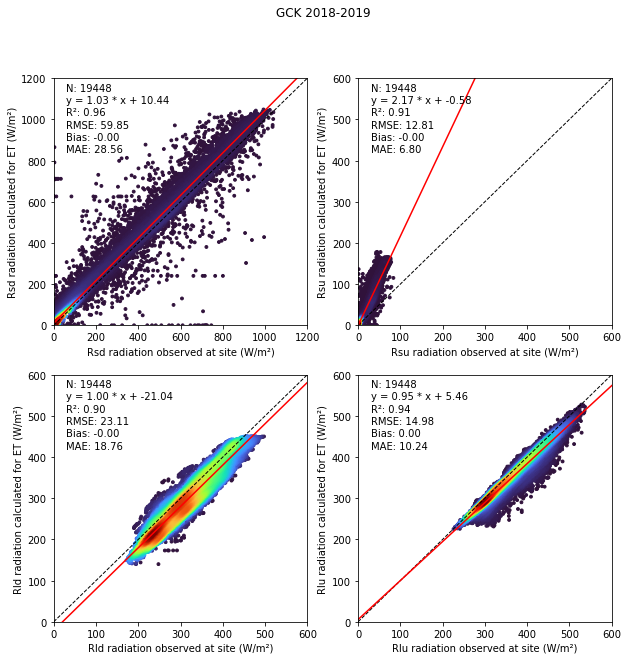

In [78]:
site_name = 'GCK'
data_labels = ['AMATERASS_Rsd', 'Rsu', 'ERA5_Rld_10min', 'RluV002']

SITE_CSV = '/disk2/Data/FluxSite4ET/validation/'+site_name+'_2018_2019_L2.csv'
csv_data = numpy.genfromtxt(SITE_CSV, delimiter=',', dtype=str)
site_obs = [half_hour_to_10min_by_nan(csv_data[:,1][1:].astype(float)), 
            half_hour_to_10min_by_nan(csv_data[:,2][1:].astype(float)), 
            half_hour_to_10min_by_nan(csv_data[:,3][1:].astype(float)), 
            half_hour_to_10min_by_nan(csv_data[:,4][1:].astype(float))]
site_cal = []
obs_timelist = None
for data_label in  data_labels:
    SITE_CAL_CSV = '/disk2/Data/FluxSite4ET/'+site_name+'_'+data_label+'.csv'
    cal_timelist, site_cal_item = read_site_csv(SITE_CAL_CSV)
    obs_timelist = cal_timelist
    site_cal.append(site_cal_item)

######################################
site_cal[0]=numpy.roll(site_cal[0], 1)
# site_cal[1]=numpy.roll(site_cal[1], 1)/1.8
site_cal[1]=numpy.roll(site_cal[1], 1)
site_cal[2]=numpy.roll(site_cal[2], -9)
site_cal[3]=numpy.roll(site_cal[3], 3)
######################################

mapping_comparison(site_obs, site_cal, site_name + ' 2018-2019', 1)

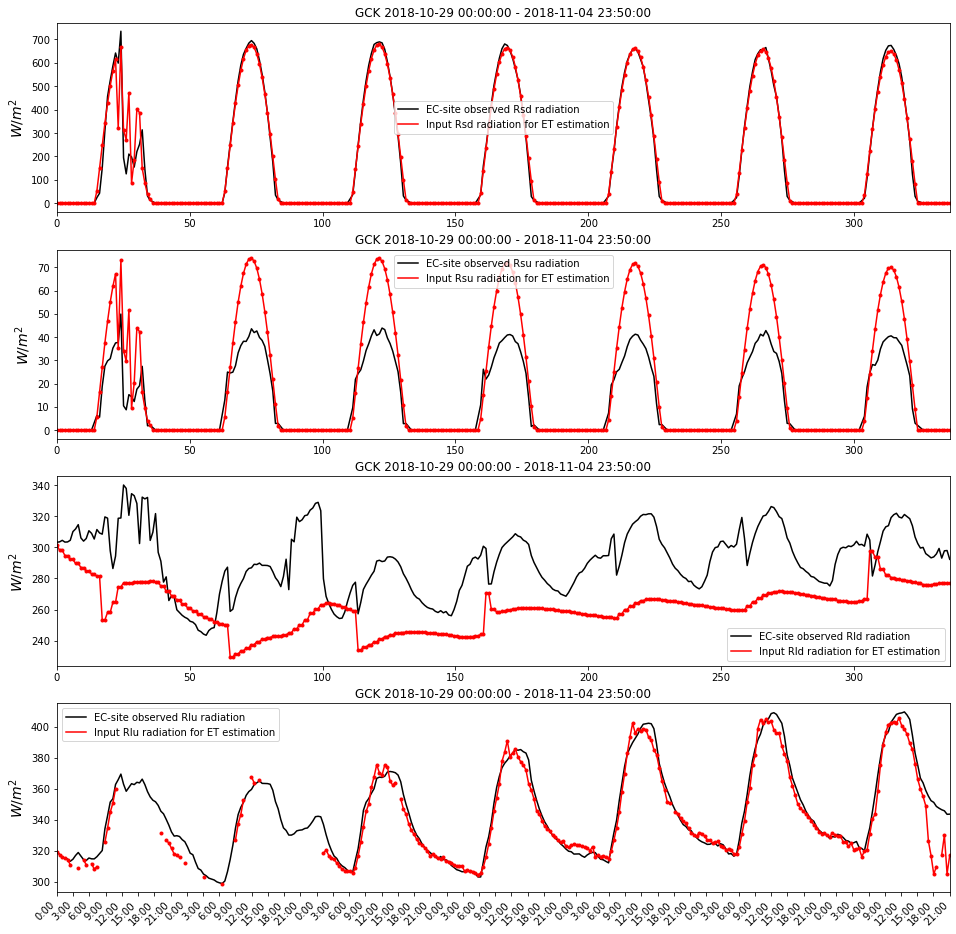

In [79]:
show_radiation_curve_week(site_name, 43, obs_timelist, site_obs, site_cal, 0)

In [80]:
r_labels = ['Rsd', 'Rsu', 'Rld', 'Rlu']
for idx in range(len(r_labels)):
    r_data = site_cal[idx]
    r_label = r_labels[idx]
    r_record = r_data.astype(str)
    r_lu_csv_ = numpy.column_stack((obs_timelist, r_record))
    numpy.savetxt(os.path.join(storage_folder, site_name+'_'+r_label+'.csv'), r_lu_csv_, delimiter=",", fmt='%s')

## GDK

N: 19309
R²: 0.9495897462569933
RMSE: 66.86519666105988
Bias: 1.2623366309759426e-14
MAE 36.64141476196964
N: 19309
R²: 0.8827213553304658
RMSE: 14.51972969122037
Bias: -6.217478928687479e-15
MAE 9.009820442940457
N: 19309
R²: 0.911390318391242
RMSE: 21.3895592282921
Bias: -4.399337363177353e-14
MAE 16.73461396077184
N: 19309
R²: 0.9340489085180533
RMSE: 15.311292900897472
Bias: 1.8534681503322143e-14
MAE 10.629217131210892


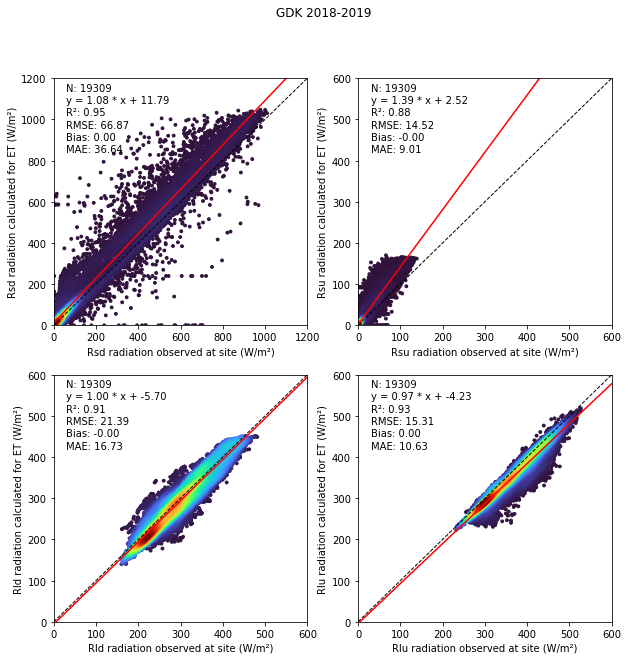

In [81]:
site_name = 'GDK'
data_labels = ['AMATERASS_Rsd', 'Rsu', 'ERA5_Rld_10min', 'RluV002']

SITE_CSV = '/disk2/Data/FluxSite4ET/validation/'+site_name+'_2018_2019_L2.csv'
csv_data = numpy.genfromtxt(SITE_CSV, delimiter=',', dtype=str)
site_obs = [half_hour_to_10min_by_nan(csv_data[:,1][1:].astype(float)), 
            half_hour_to_10min_by_nan(csv_data[:,2][1:].astype(float)), 
            half_hour_to_10min_by_nan(csv_data[:,3][1:].astype(float)), 
            half_hour_to_10min_by_nan(csv_data[:,4][1:].astype(float))]
site_cal = []
obs_timelist = None
for data_label in  data_labels:
    SITE_CAL_CSV = '/disk2/Data/FluxSite4ET/'+site_name+'_'+data_label+'.csv'
    cal_timelist, site_cal_item = read_site_csv(SITE_CAL_CSV)
    obs_timelist = cal_timelist
    site_cal.append(site_cal_item)

######################################
site_cal[0]=numpy.roll(site_cal[0], 3)
# site_cal[1]=numpy.roll(site_cal[1], 3)/1.45
site_cal[1]=numpy.roll(site_cal[1], 3)
site_cal[2]=numpy.roll(site_cal[2], -9)
# site_cal[3]=numpy.roll(site_cal[3], 6)+2
site_cal[3]=numpy.roll(site_cal[3], 6)
######################################

mapping_comparison(site_obs, site_cal, site_name + ' 2018-2019', 1)

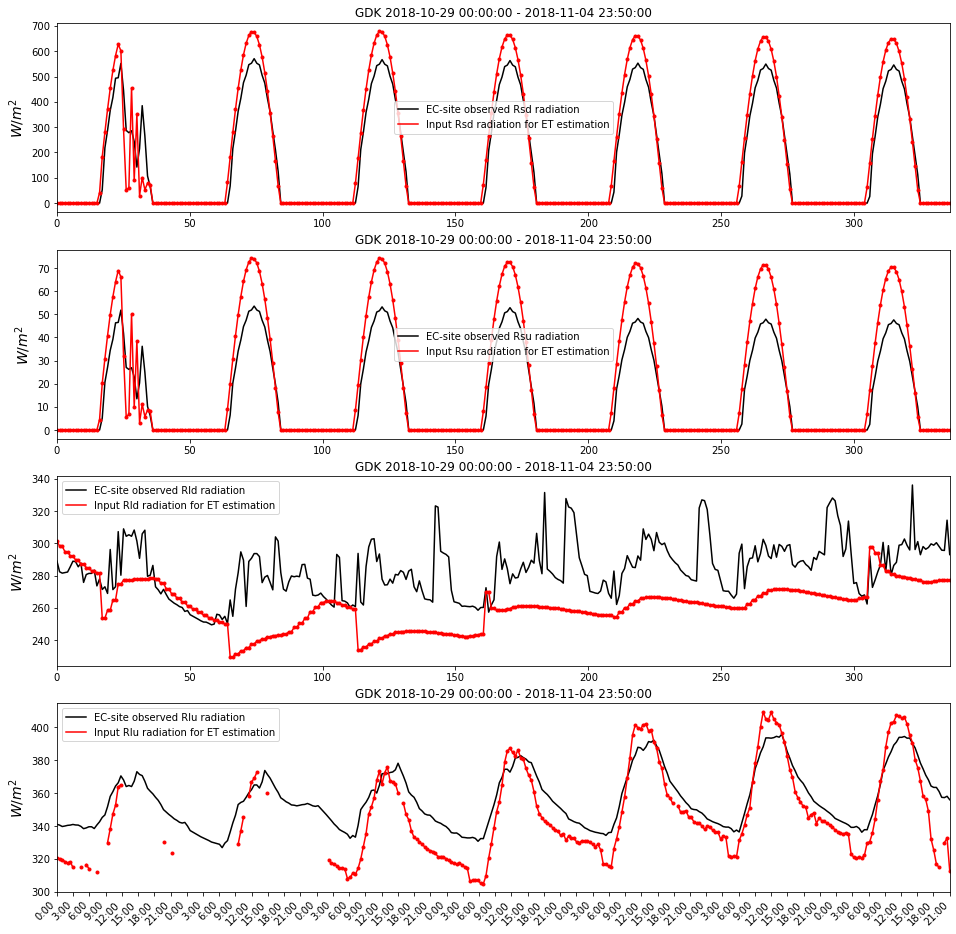

In [70]:
show_radiation_curve_week(site_name, 43, obs_timelist, site_obs, site_cal, 0)

In [71]:
r_labels = ['Rsd', 'Rsu', 'Rld', 'Rlu']
for idx in range(len(r_labels)):
    r_data = site_cal[idx]
    r_label = r_labels[idx]
    r_record = r_data.astype(str)
    r_lu_csv_ = numpy.column_stack((obs_timelist, r_record))
    numpy.savetxt(os.path.join(storage_folder, site_name+'_'+r_label+'.csv'), r_lu_csv_, delimiter=",", fmt='%s')

## TKY

N: 7388
R²: 0.9481500809002842
RMSE: 70.74622482237199
Bias: 1.8958064980107058e-14
MAE 35.51868836878082
N: 7388
R²: 0.7600955037249942
RMSE: 30.676509678385443
Bias: -2.954503633263438e-15
MAE 15.178374037753002
N: 7388
R²: 0.8192771468106956
RMSE: 24.13635457791459
Bias: -1.9942899524528204e-14
MAE 18.666634335972066
N: 7388
R²: 0.8996705635370994
RMSE: 17.486511752292852
Bias: 5.539694312368946e-16
MAE 12.761749784202326


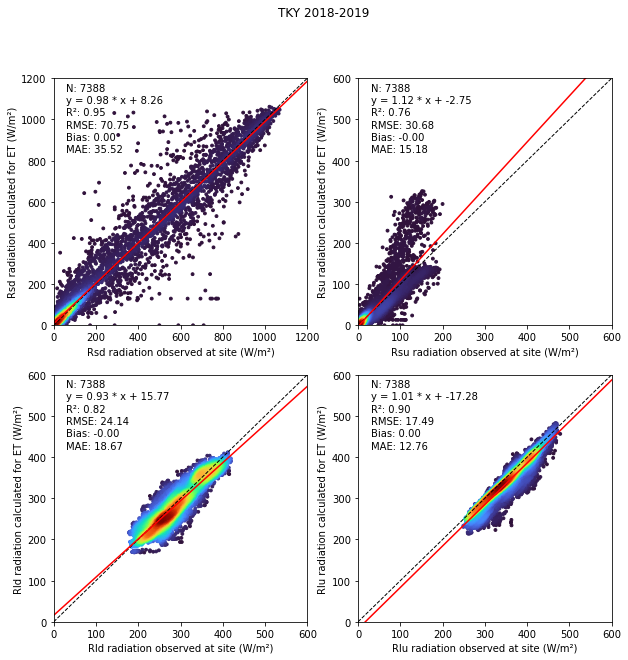

In [72]:
def half_hour_to_10min_by_nan_2y(arr_half_hour):
    new_len = 3 * len(arr_half_hour)
    arr_10min = numpy.full(new_len, numpy.nan)
    arr_10min[::3] = arr_half_hour
    nan_10min = numpy.full(len(arr_10min), numpy.nan)
    arr_10min_2y = numpy.concatenate((arr_10min, nan_10min))
    return arr_10min_2y


site_name = 'TKY'
data_labels = ['AMATERASS_Rsd', 'Rsu', 'ERA5_Rld_10min', 'RluV002']

SITE_CSV = '/disk2/Data/FluxSite4ET/validation/'+site_name+'_2018.csv'
csv_data = numpy.genfromtxt(SITE_CSV, delimiter=',', dtype=str)
site_obs = [half_hour_to_10min_by_nan_2y(csv_data[:,3][1:].astype(float)), 
            half_hour_to_10min_by_nan_2y(csv_data[:,4][1:].astype(float)), 
            half_hour_to_10min_by_nan_2y(csv_data[:,5][1:].astype(float)), 
            half_hour_to_10min_by_nan_2y(csv_data[:,6][1:].astype(float))]
site_cal = []
obs_timelist = None
for data_label in  data_labels:
    SITE_CAL_CSV = '/disk2/Data/FluxSite4ET/'+site_name+'_'+data_label+'.csv'
    cal_timelist, site_cal_item = read_site_csv(SITE_CAL_CSV)
    obs_timelist = cal_timelist
    site_cal.append(site_cal_item)

######################################
# site_cal[0]=numpy.roll(site_cal[0], 1)
# site_cal[1]=numpy.roll(site_cal[1], 1)/1.45
site_cal[2]=numpy.roll(site_cal[2], -9)
# site_cal[3]=numpy.roll(site_cal[3], 3)+2
######################################

mapping_comparison(site_obs, site_cal, site_name + ' 2018-2019', 1)

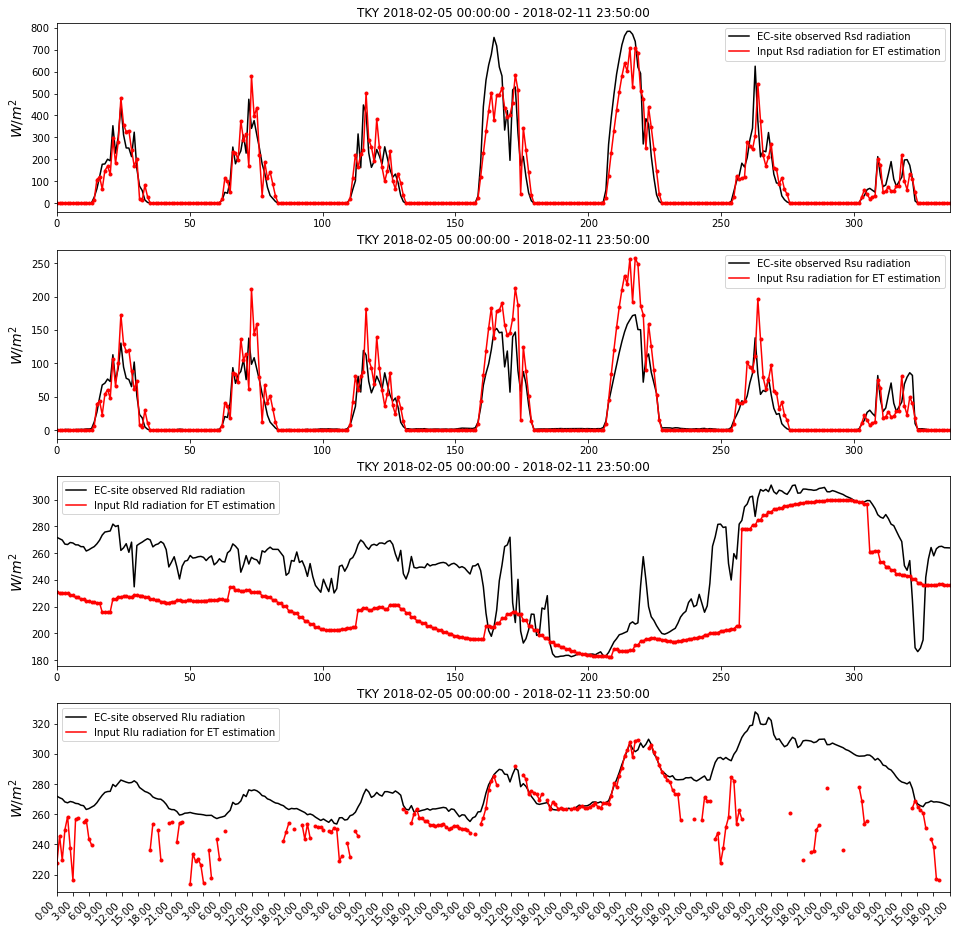

In [73]:
show_radiation_curve_week(site_name, 5, obs_timelist, site_obs, site_cal, 0)

In [74]:
r_labels = ['Rsd', 'Rsu', 'Rld', 'Rlu']
for idx in range(len(r_labels)):
    r_data = site_cal[idx]
    r_label = r_labels[idx]
    r_record = r_data.astype(str)
    r_lu_csv_ = numpy.column_stack((obs_timelist, r_record))
    numpy.savetxt(os.path.join(storage_folder, site_name+'_'+r_label+'.csv'), r_lu_csv_, delimiter=",", fmt='%s')